## Planejamento do processo

### Definição do problema

#### Definir o problema a ser respondido com máxima precisão

Objetivo estratégico: 

    I - Identificar MCU dos parceiros que são considerados outliers em consultas

Objetivo estratégico: 
    
    Sendo, o 'custo total' de consulta por proposta, uma das variáveis que compõe a [MCU](https://sebrae.com.br/sites/PortalSebrae/artigos/margem-de-contribuicao-voce-sabe-calcular,24d2b05a4c7c3810VgnVCM100000d701210aRCRD), definiremos quando esta variável começa a influenciar negativamente o MCU. Consideraremos **prejuízo** as propostas que retornarem MCU <= 0.00.

Para tanto, aplicaremos a seguinte fórmula:

$$MCU = PVU – (CVU + DVU)$$


Sendo:

**Preço de Venda Unitário (PVU)**: O valor pelo qual você vende uma unidade do seu produto ou serviço. 

**Custo Variável Unitário (CVU)**: Os gastos que variam diretamente com a produção ou venda de uma unidade do produto. 

**Despesa Variável Unitária (DVU)**: Gastos que também variam conforme a produção ou a venda, mas não estão diretamente ligados ao custo de produção em si.




#### Modelar os testes de hipóteses inicialmente necessários para confirmação do problema


1 - Correlacáo entre o volume de consultas e propostas pagas:
    H0: O volume de consultas é altamente correlacionado ä quantidade de propostas pagas.

#### Definir as métricas de validação e acompanhamento da solução

Inicialmente, a MCU será usada como métrica de acompanhamento de eficiência do parceiro, para fins de consulta.

### Verificação dos dados

#### Definir quais dados são necessários

I - Dados de consultas

II - Dados das propostas importadas


#### Como podem ser acessados

I - Dados de consultas


Estão hospedados no clickhouse, acessados pela integração com o debeaver.


II - Dados das propostas importadas


Estão hospedados num DB postgres na cloud, acessados pela integração com o debeaver.


#### Qual é o período definido para análise

Será analisado o histórico de produção dos últimos 12 meses.

#### Qual é a granularidade necessária para análise

Granularidade mínima (por consulta), conforme objetivos declarados acima.

### EDA inicial

Carga da amostra

Dados das consultas - clickhouse (sem agregação):

Parâmetros da pesquisa:

    - Período (01/09/2025 - 30/09/2025)

    - Parceiro: 7560 (Thiago) - master

    - Apenas consultas não cacheadas


Atributos:

    - chave única da consulta

    - data (timestamp)

    - cpf do cliente

    - provider

    - valor por consulta

    - Valor da proposta consultada



    

Dados dos contratos - core (sem agregação):

Parâmetros da pesquisa:

    - Período (01/09/2025 - 30/09/2025)

    - Parceiro: 7560 (Thiago) - master

    - Apenas contratos pagos



Atributos:

    - chave única do contrato

    - data (timestamp)

    - cpf do cliente

    - provider

    - Todos os valores recebidos na proposta (TAC, seguro, agio, etc)

    - Valor de operação

    - Valor de emissão

    - contract_number



OBS: precisarei fazer um join entre os contratos pagos e a sua respectiva consulta. Então, precisamos trazer as chaves que se relacionam entre as 2 tabelas.

clickhouse

Consegui localizar a maioria dos atributos.
No momento, estou tentando entender o relacionamento entre a consulta realizada e o log salvo no DB

#### Criando massa de dados simulados

In [4]:
import numpy as np
from datetime import datetime, timedelta
import random
import pandas as pd

**consultas**

In [23]:
ids = np.arange(500)

In [24]:
# gerando id

# gerando datas
start_date = "2025-09-01 00:00:00"
end_date = "2025-09-30 23:59:59"

start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")

interval = end_date - start_date

random_dates = []

for _ in range(500):
    random_seconds = random.randint(0, int(interval.total_seconds()))
    random_date = start_date + timedelta(seconds=random_seconds)
    random_dates.append(random_date)

for date in random_dates[:10]:
    print(date)

# Gerando CPF aleatório
cpfs = ["".join(str(random.randint(0,9)) for _ in range(11)) for _ in range(500)]
providers = np.random.choice(['BMS', 'QI'], size=500, replace=True)
valor_consult = .25
valor_proposta_consulta = np.random.normal(loc = 98.00, scale = 50.00, size = 500)


2025-09-08 10:08:59
2025-09-28 10:53:40
2025-09-04 15:38:45
2025-09-22 20:06:23
2025-09-11 12:48:38
2025-09-22 22:32:31
2025-09-26 04:44:49
2025-09-20 02:47:38
2025-09-03 23:41:16
2025-09-05 10:30:58


**Propostas**

In [25]:
dados_proposta = pd.DataFrame({'ids' : np.random.choice(ids, 500),
                              'random_dates' : np.random.choice(random_dates, 500),
                              'cpfs' : np.random.choice(cpfs, 500),
                              "valor_operacao" : np.random.choice(valor_proposta_consulta, 500),
                              "valor_emissao" : np.random.choice(valor_proposta_consulta * .95, 500),
                              "contract_number" : ["".join(str(random.randint(0,9)) for _ in range(11)) for _ in range(500)],
                              "custo_averacao" : .65,
                              "custo_formalizacao" : 2.65})
dados_proposta['comissao_comercial'] = dados_proposta['valor_emissao'] * .01
dados_proposta['comissao_repassada'] = dados_proposta['valor_emissao'] * .30
dados_proposta['tac'] = dados_proposta['valor_emissao'] * .30
dados_proposta['seguro'] = dados_proposta['valor_emissao'] * .30
dados_proposta['agio'] = dados_proposta['valor_emissao'] * .30

dados_proposta

,ids,random_dates,cpfs,valor_operacao,valor_emissao,contract_number,custo_averacao,custo_formalizacao,comissao_comercial,comissao_repassada,tac,seguro,agio
0,279,2025-09-12 10:19:45,03746507624,91.358347,16.686639,72915135476,0.65,2.65,0.166866,5.005992,5.005992,5.005992,5.005992
1,174,2025-09-17 19:35:36,16336755780,107.582886,69.184705,75133280050,0.65,2.65,0.691847,20.755411,20.755411,20.755411,20.755411
2,290,2025-09-09 18:30:16,72952530357,80.954199,115.836972,39393612731,0.65,2.65,1.158370,34.751092,34.751092,34.751092,34.751092
3,16,2025-09-11 04:49:21,61773512950,145.723424,163.216267,93416013436,0.65,2.65,1.632163,48.964880,48.964880,48.964880,48.964880
4,458,2025-09-14 01:37:43,24298156825,31.854551,10.856800,61551007664,0.65,2.65,0.108568,3.257040,3.257040,3.257040,3.257040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,46,2025-09-18 06:20:02,64034382958,122.420628,96.587330,28033151095,0.65,2.65,0.965873,28.976199,28.976199,28.976199,28.976199
496,145,2025-09-20 08:48:34,40968725589,68.027062,49.422426,80667718113,0.65,2.65,0.494224,14.826728,14.826728,14.826728,14.826728
497,24,2025-09-13 08:46:52,81563151396,76.409526,107.430504,62827838111,0.65,2.65,1.074305,32.229151,32.229151,32.229151,32.229151
498,198,2025-09-03 04:46:05,56398720393,110.481407,118.860374,87689926563,0.65,2.65,1.188604,35.658112,35.658112,35.658112,35.658112


**Consultas**

In [26]:
for _ in range(400):
    ids[np.random.choice(ids, np.random.randint(20,50))] = np.random.choice(ids, 1)

In [27]:
dados_consulta = pd.DataFrame({'ids' : ids,
                              'random_dates' : random_dates,
                              'cpfs' : cpfs, 
                              'providers' : providers,
                              'valor_proposta_consulta' : valor_proposta_consulta})

In [28]:
ids_duplicados = dados_consulta[dados_consulta['ids'].duplicated(keep=False)]['ids'].unique()

for id in ids_duplicados:
    primeira_ocorrencia = dados_consulta[dados_consulta['ids'] == id].iloc[0]
    
    dados_consulta.loc[dados_consulta['ids'] == id, 'cpfs'] = primeira_ocorrencia['cpfs']
    dados_consulta.loc[dados_consulta['ids'] == id, 'valor_proposta_consulta'] = primeira_ocorrencia['valor_proposta_consulta']


In [29]:
len(dados_consulta.ids.unique())

12

In [30]:
# merge dos dados
dados_finais = pd.merge(right=dados_consulta, left=dados_proposta, how= 'left', on = 'cpfs')

In [31]:
#dados_finais.to_csv('../../output_data/datasets/sinteticos.csv', index=False)

#### Confirmar se os dados suportam a resolução do problema levantado


Obtendo o valor médio destas variáveis (Não vamos analisar toda a base de logs, teremos apenas uma amostra, por isso, vamos analisar o valor médio)

In [32]:
# Verificação de outliers
# Calculando numero de classes
from scipy.stats import kurtosis, skew, norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

In [33]:
## Validando suposições estatísticas para o cálculo da média - Os valores custo_averbação e custo_formalizacao são constantes, e serão obtidos a partir da agregação das consultas e propostas. Analisando comissao_comercial.

# Suposição de normalidade na distribuição

#### retorna distribuição

In [34]:

def retorna_distribuicao(df: pd.DataFrame, atributo: str, aplicar_log: bool = False):


    df = df.groupby(['cpfs']).agg({f'{atributo}': 'sum'}).reset_index()

    if aplicar_log:
            df[atributo] = np.log(df[atributo])

    bins_histogram = round(np.sqrt(df[atributo].shape[0]))


    # Calculando assimetria e kurtose
    skewness = skew(df[~df[atributo].isna()][atributo])
    kurtosis_ = kurtosis(df[~df[atributo].isna()][atributo])


    # Validação estatística - suposição de normalidade na distribuição
    # calculando distribuição normal teórica

    # definindo parâmetros
    media = df[atributo].mean()
    desvio = df[atributo].std()

    # bins
    x = np.linspace(df[atributo].min(), df[atributo].max(), 100)

    # gerando normal
    normal_teorica = norm.pdf(x, media, desvio)

    counts, bin_edges = np.histogram(df[atributo].dropna(), bins=bins_histogram)
    bin_width = bin_edges[1] - bin_edges[0]

    # Ajusta escala da curva normal ao histograma (para frequência e não densidade)
    normal_teorica = normal_teorica * len(df[atributo].dropna()) * bin_width

    # Visualização

    #plt.figure(figsize=(10,4))

    # Gráficos
    chart = sns.histplot(df[[atributo]], bins=bins_histogram, kde = True, color='#dda0dd')
    # Curva normal teórica sobreposta
    plt.plot(x, normal_teorica, color='red', linestyle='--', linewidth=2, label='Normal teórica')
    #média
    plt.axvline(df[atributo].mean(), color='blue', linestyle='--', linewidth=2, label='Média')
    #mediana
    plt.axvline(df[atributo].median(), color='purple', linestyle='--', linewidth=2, label='Média')



    # Ambiente
    sns.set_style('whitegrid',
                    {'grid.linestyle':':'})
    chart.grid(alpha = 0.5)
    sns.set(font_scale = 1.5)
    sns.set_palette('prism')

    # Eixos
    chart.set_ylabel("Frequência",
                    fontsize = 10,
                    alpha = 0.8)

    chart.set_xlabel("Idade",
                    fontsize = 10,
                    alpha = 0.8)

    chart.tick_params(axis = 'y', labelsize = 12)


    # Título e subtítulo
    chart.text(s = "Distribuição - ",
            x = -0.5,
            y = 120,
            fontsize = 17,
            fontweight = 'bold',
            alpha = .85);



    chart.text(s = 'Skewness: ' + str(round(skewness, 5)),
            x = -.5,
            y = 100,
            fontsize = 10,
            fontweight = 'bold',
            alpha = .85);


    chart.text(s = 'Kurtosis: ' + str(round(kurtosis_, 5)),
            x = -.5,
            y = 80,
            fontsize = 10,
            fontweight = 'bold',
            alpha = .85);

    chart.legend(title = 'Densidade: ',
                title_fontsize = 10,
                labels = ["Original", "Normal-teórica", "Média", "Mediana"],
                fontsize = 8,
                borderpad = 1.5,
                labelspacing = 1,
                edgecolor = 'black');

### Visualizando

In [78]:
cpfs_counts = pd.DataFrame(dados_finais.cpfs.value_counts()
)

In [77]:
cpfs_df = pd.DataFrame({
    "cpfs": cpfs_counts.index,
    "counts": cpfs_counts 
})

cpfs_df.reset_index(drop=True)

,cpfs,counts
0,03374244540,133
1,68080385772,78
2,02313550477,44
3,58179392243,33
4,01439377288,30
...,...,...
313,27207505502,1
314,67114873847,1
315,54805348301,1
316,46457622191,1


In [80]:
cpfs_df['custo_averacao'] = .65
cpfs_df['custo_formalizacao'] = 2.86
cpfs_df['custo_consult'] = cpfs_df['counts'] *  .25


In [83]:
cpfs_df = cpfs_df.reset_index(drop=True)

<Axes: >

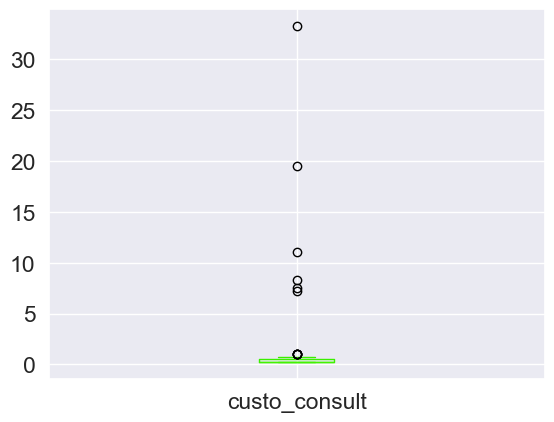

In [84]:
cpfs_df.custo_consult.plot(kind='box')

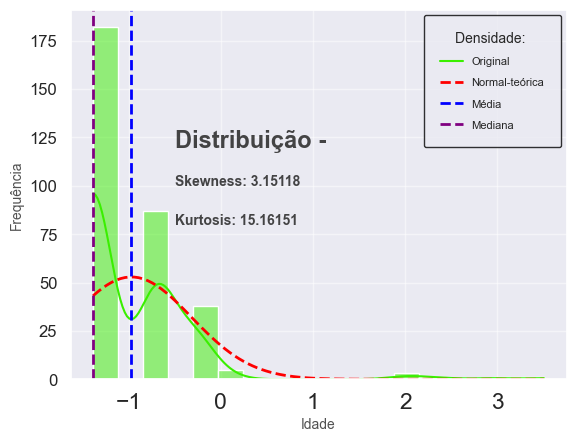

In [87]:
retorna_distribuicao(df= cpfs_df, atributo='custo_consult', aplicar_log=True)

In [88]:
print("Média - Comissao comercial")
np.exp(np.mean(np.log(cpfs_df['custo_consult'])))

Média - Comissao comercial


0.3789604937043021

In [44]:
print("Média - Comissao repassada")
np.exp(np.mean(np.log(dados_finais['comissao_repassada'])))

Média - Comissao repassada


21.49323389081461

Validada as suposições estatísticas para cálculo da média, passa-se ao cálculo da métrica
Compondo CVU (custo_averbacao, custo_formalizacao, comissao_comercial, comissao_repassada, custo_consult)

CVU ideal

In [89]:
# composicao do custoDados_Indicadores
custo_averbacao = .65
custo_formalizacao = 2.65
comissao_comercial = 0.71
comissao_repassada = 21.49
custo_consult = 0.37
cvu = custo_averbacao + custo_formalizacao + comissao_comercial + comissao_repassada + custo_consult
cvu

25.87

In [55]:
print("Média - Comissao tac")
print(np.exp(np.mean(np.log(dados_finais['tac']))))

print("Média - seguro")
print(np.exp(np.mean(np.log(dados_finais['agio']))))

print("Média - agio")
print(np.exp(np.mean(np.log(dados_finais['seguro']))))

Média - Comissao tac
21.49323389081461
Média - seguro
21.49323389081461
Média - agio
21.49323389081461


c:\Users\Cleiton - Financeiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [98]:
df_final = pd.merge(left=dados_finais[['cpfs', 'comissao_comercial', 'comissao_repassada', "tac",	"seguro",	'agio']], right=cpfs_df, how='right', left_index=True, right_index=True)

In [99]:
df_final

,cpfs_x,comissao_comercial,comissao_repassada,tac,seguro,agio,cpfs_y,counts,custo_averacao,custo_formalizacao,custo_consult
0,03746507624,0.166866,5.005992,5.005992,5.005992,5.005992,03374244540,133,0.65,2.86,33.25
1,16336755780,0.691847,20.755411,20.755411,20.755411,20.755411,68080385772,78,0.65,2.86,19.50
2,72952530357,1.158370,34.751092,34.751092,34.751092,34.751092,02313550477,44,0.65,2.86,11.00
3,61773512950,1.632163,48.964880,48.964880,48.964880,48.964880,58179392243,33,0.65,2.86,8.25
4,24298156825,0.108568,3.257040,3.257040,3.257040,3.257040,01439377288,30,0.65,2.86,7.50
...,...,...,...,...,...,...,...,...,...,...,...
313,03374244540,0.463643,13.909303,13.909303,13.909303,13.909303,27207505502,1,0.65,2.86,0.25
314,03374244540,0.463643,13.909303,13.909303,13.909303,13.909303,67114873847,1,0.65,2.86,0.25
315,03374244540,0.463643,13.909303,13.909303,13.909303,13.909303,54805348301,1,0.65,2.86,0.25
316,03374244540,0.463643,13.909303,13.909303,13.909303,13.909303,46457622191,1,0.65,2.86,0.25


In [ ]:
def return_mcu():

    tac = df_final['tac']
    agio = df_final['agio']
    seguro = df_final['seguro']
    
    
    cms_repassada = df_final['comissao_repassada']
    cms_comercial = df_final['comissao_comercial']
    custo_consulta = df_final['custo_consult']


In [57]:
tac = 21.49
seguro = 21.49
agio = 21.49

pvu = tac + seguro + agio
pvu

64.47

In [58]:
mcu = pvu - cvu
mcu

38.97

#### Confirmar se os dados suportam os testes de hipóteses modelados